## FPoliSolutions, LLC; Asset Monitoring and Predictive Maintenance
### Main Draft

#### Arnab Dey Sarkar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

In [6]:
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from patsy import dmatrices

In [7]:
df = pd.read_csv("training_data.csv")

#### Loading data

In [8]:
df=df.dropna().copy()

In [20]:
input_names = df.drop(columns=['Y']).columns
lf= df.copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'Y'], value_vars=input_names, ignore_index=True)

In [21]:
high_skew_inputs = input_names[ np.abs(df.drop(columns=['Y']).skew()) > 1 ]

In [22]:
high_skew_inputs

Index(['Z07', 'Z08', 'Z09', 'V02', 'V11', 'V27', 'V28', 'V29'], dtype='object')

In [23]:
# check if the values are negative because the log and square root transformations cannot be applied to negative values
lf.loc[ (lf.variable.isin(high_skew_inputs)) & (lf.value < 0), :].groupby(['variable']).size()

variable
V02    110
V11    119
V29    215
Z09    136
dtype: int64

In [24]:
lf_skew = lf.loc[ lf.variable.isin(high_skew_inputs), :].copy()

lf_skew = lf_skew.loc[ ~lf_skew.variable.isin(['V02', 'V11', 'V29', 'Z09']), :].copy()

In [25]:
lf_skew['shift_value'] = 1 - lf_skew.value
lf_skew['log_shift_value'] = np.log( lf_skew.shift_value )

In [26]:
# Convert to short format using pivot
data = lf_skew.pivot(index='rowid', columns='variable', values='log_shift_value').reset_index()
data = data.drop(columns=['rowid'])

In [27]:
df_transformed = df.copy()
df_transformed = df_transformed.drop(columns=['Z07','Z08','V27','V28'])


In [28]:
df_transformed['Z07'] = data['Z07']
df_transformed['Z08'] = data['Z08']
df_transformed['V27'] = data['V27']
df_transformed['V28'] = data['V28']

In [32]:
lf= df.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'Y']).copy()

In [36]:
df_part_features = df[['X01','X02','Z01','Z02', 'V01', 'V02','Y' ]].copy()
df_part_features.melt(ignore_index=False)
lf_part = df_part_features.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'Y'])

In [37]:
df_clean=df.dropna().copy()

In [38]:
df_clean['Y']=df_clean.Y.astype('category')

In [53]:
df_clean_copy=df.copy()

df_clean_copy_features = df_clean_copy.drop(columns=['Y'])

In [85]:
# Standardize original data df

df_features = df.drop(columns=['Y'])

In [86]:
# Let's now standardize the numeric columns
X_features = StandardScaler().fit_transform(df_features )

In [87]:
# Convert the standardized features to a DataFrame
df_standardized = pd.DataFrame(X_features, columns=df_features.columns)


In [88]:
df_features_transformed = df_transformed.drop(columns=['Y'])

In [89]:
# Let's now standardize the numeric columns
X_features_transformed = StandardScaler().fit_transform(df_features_transformed )
X_features_transformed.shape

(223, 63)

In [90]:
# Convert the standardized features to a DataFrame
df_standardized_transformed = pd.DataFrame(X_features_transformed, columns=df_features_transformed.columns)



In [91]:
df_standardized['Y'] = df.Y

In [92]:
df_standardized_transformed['Y'] = df.Y

**Complex Model** PCA and interaction

In [39]:
xinputs_transformed = df_transformed.select_dtypes('number').copy()
youtput_transformed = df_transformed.loc[:, ['Y']].copy()

In [40]:
#Convert the DataFrames to NumPy arrays.
x_train_transformed = xinputs_transformed.to_numpy()
y_train_transformed = youtput_transformed.Y.to_numpy().ravel()

In [97]:
# Apply PCA to the transformed inputs and create linear additive features from the PCs.

X_pca_transformed = PCA().fit_transform(X_features_transformed)


In [100]:
df_pca_transformed = pd.DataFrame( X_pca_transformed, 
                             columns=['pc%02d' % d for d in range(1, X_pca_transformed .shape[1]+1)])

In [101]:
df_pca_transformed_add = df_pca_transformed.iloc[:, :13].copy()
df_pca_transformed_add['Y'] = df_standardized_transformed.Y

#### EDA

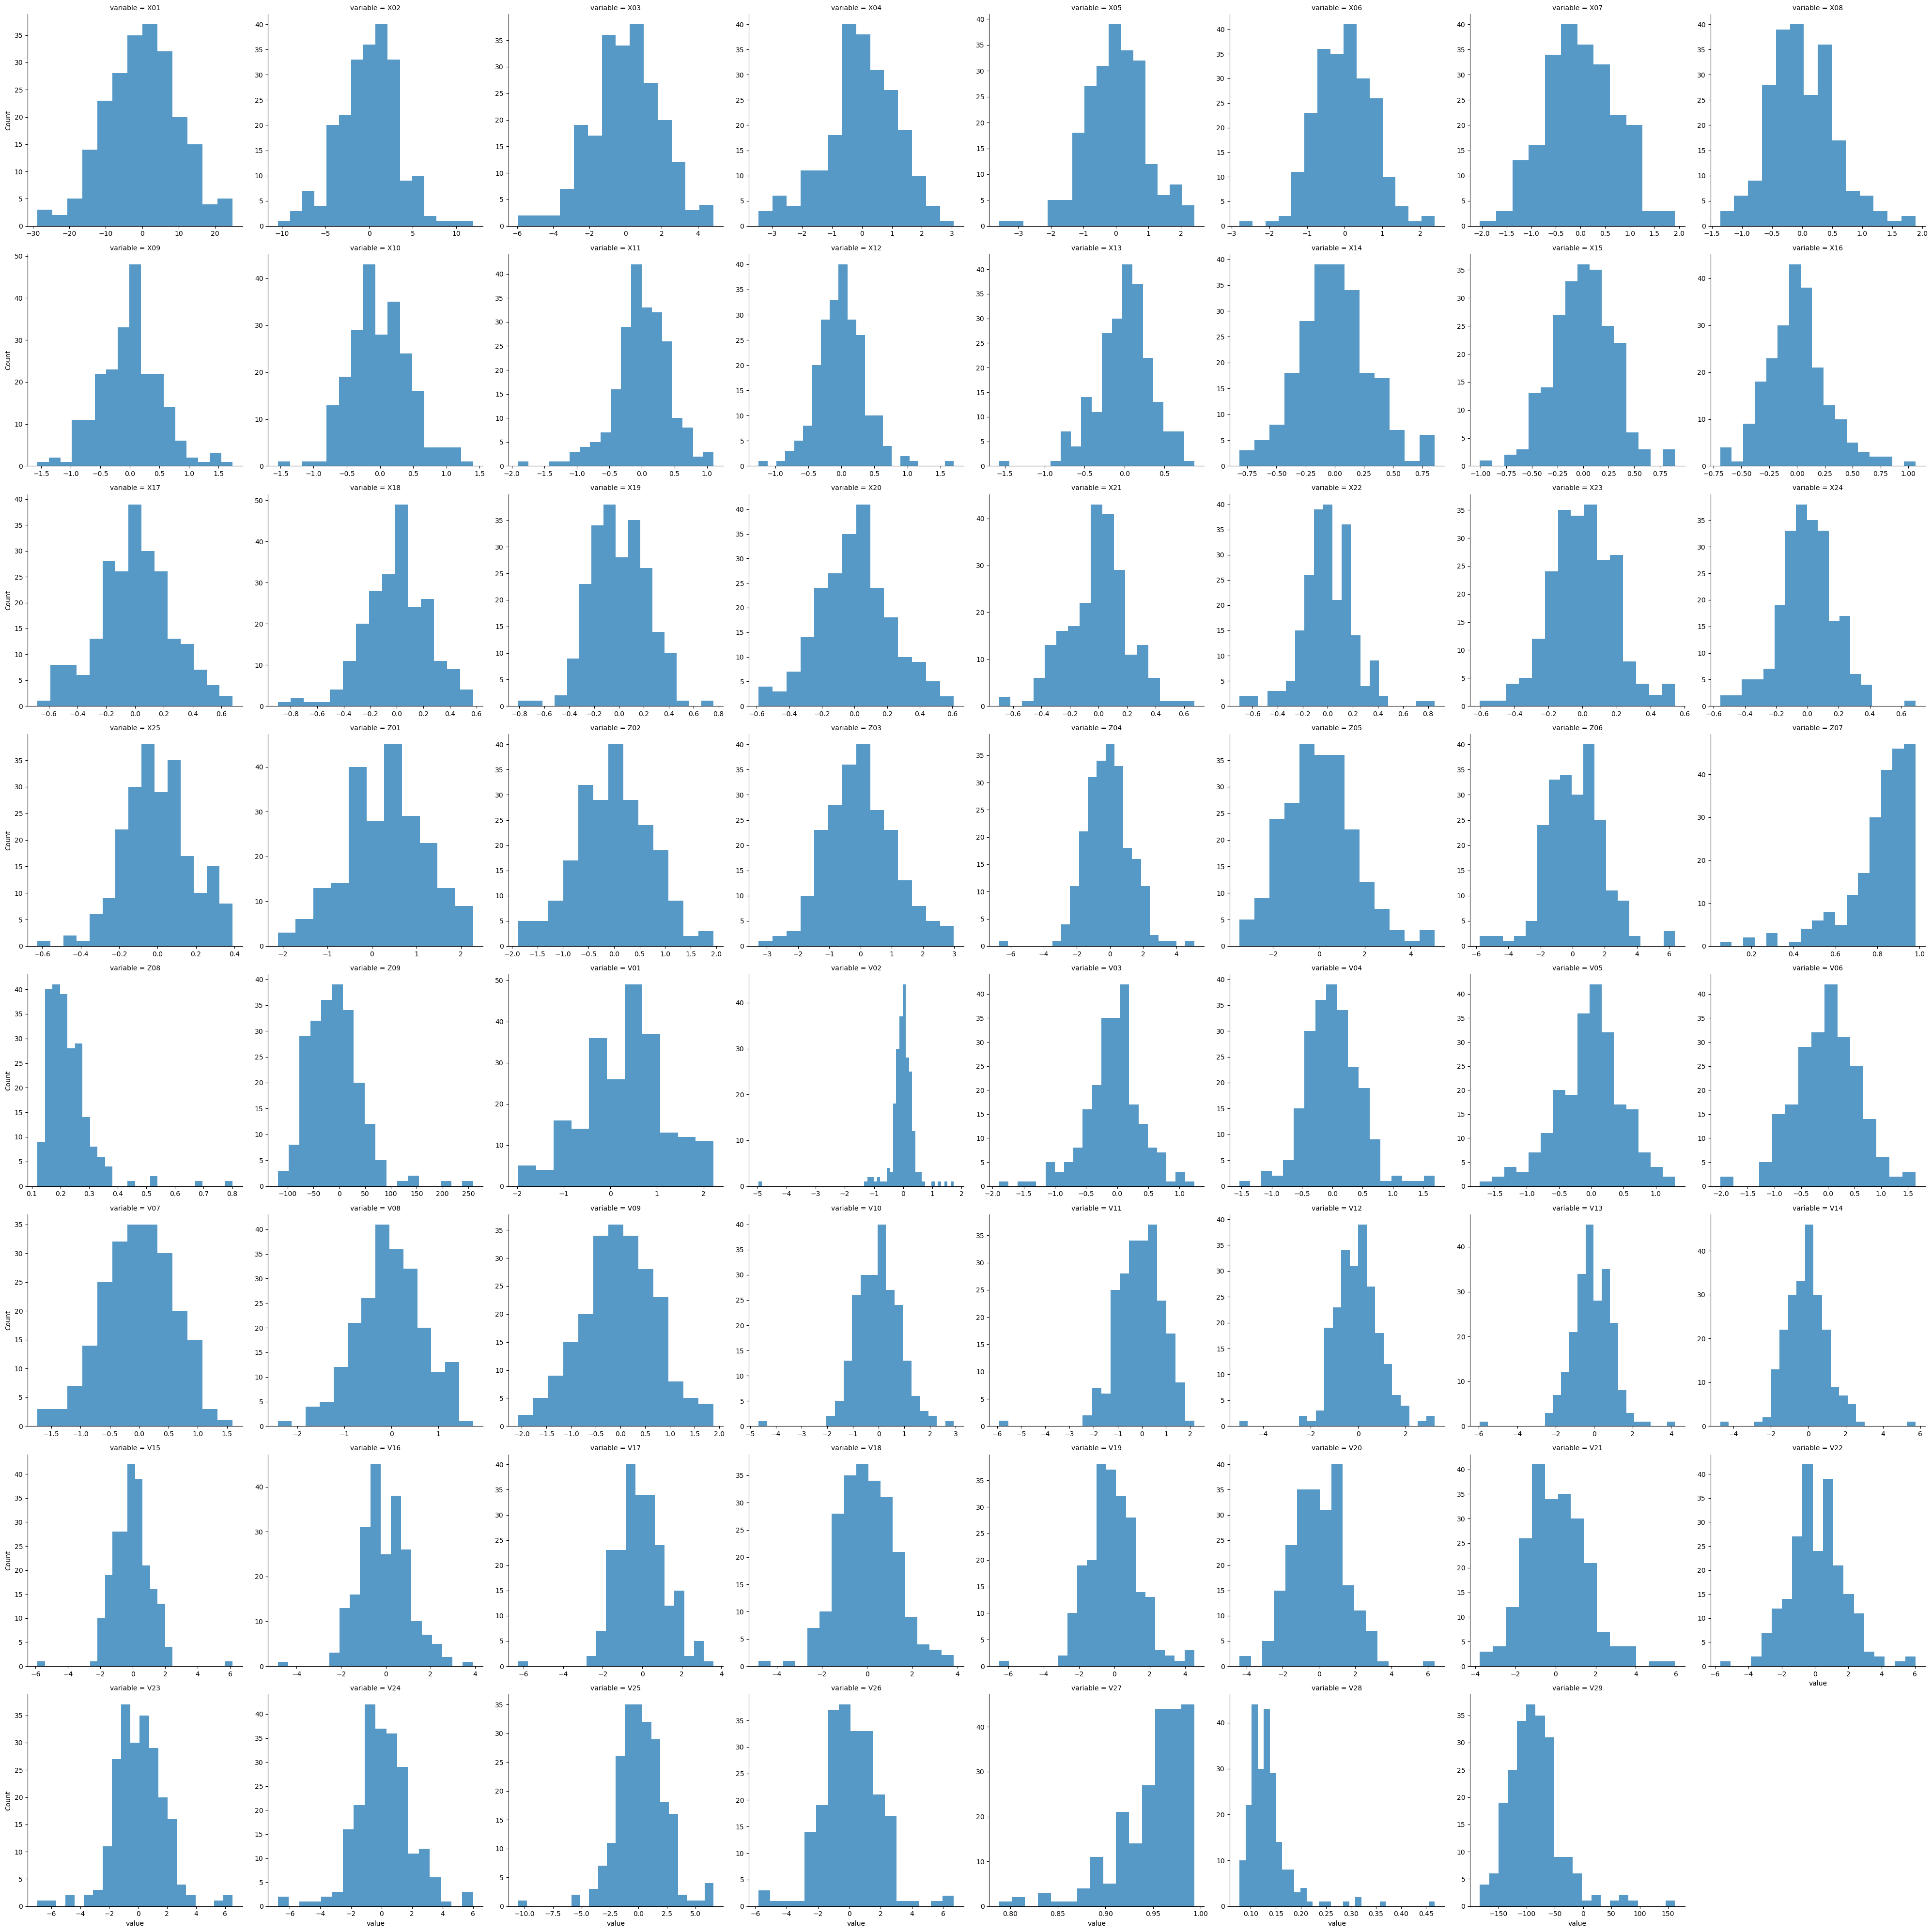

In [41]:
sns.displot(data=lf, kind='hist', x='value', col='variable', col_wrap=8,
            common_bins=False, common_norm=False,
            facet_kws={'sharex':False, 'sharey': False})

plt.show()

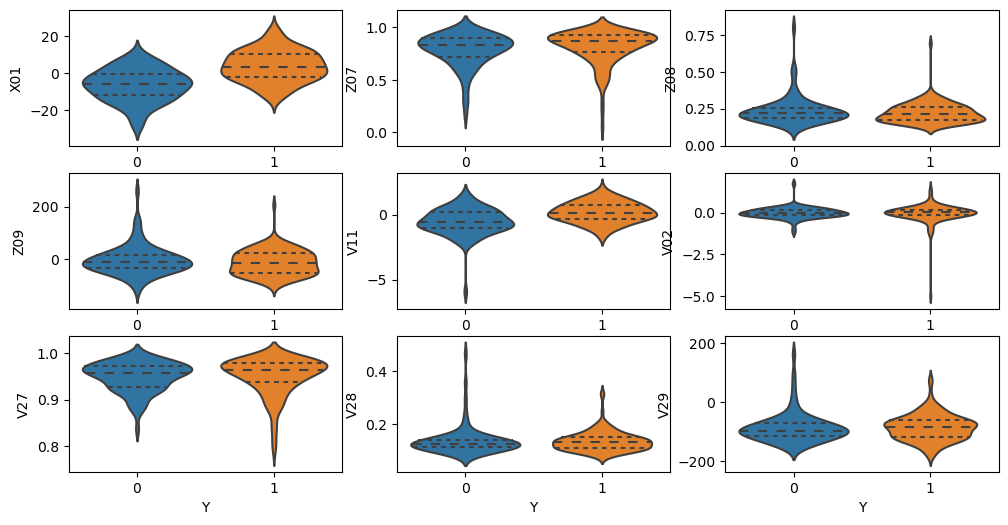

In [46]:
fig, axs = plt.subplots(3,3,figsize=(12,6))

sns.violinplot(data=df_clean, x='Y', y='X01', inner='quartile', ax=axs[0,0])
sns.violinplot(data=df_clean, x='Y', y='Z07', inner='quartile', ax=axs[0,1])
sns.violinplot(data=df_clean, x='Y', y='Z08', inner='quartile', ax=axs[0,2])

sns.violinplot(data=df_clean, x='Y', y='Z09', inner='quartile', ax=axs[1,0])
sns.violinplot(data=df_clean, x='Y', y='V11', inner='quartile', ax=axs[1,1])
sns.violinplot(data=df_clean, x='Y', y='V02', inner='quartile', ax=axs[1,2])

sns.violinplot(data=df_clean, x='Y', y='V27', inner='quartile', ax=axs[2,0])
sns.violinplot(data=df_clean, x='Y', y='V28', inner='quartile', ax=axs[2,1])
sns.violinplot(data=df_clean, x='Y', y='V29', inner='quartile', ax=axs[2,2])


plt.show()

We can see 'Z07', 'Z08', 'Z09', 'V02', 'V11', 'V27', 'V28', 'V29' are highly skewed so we had to apply log transformation to reduce their effect.

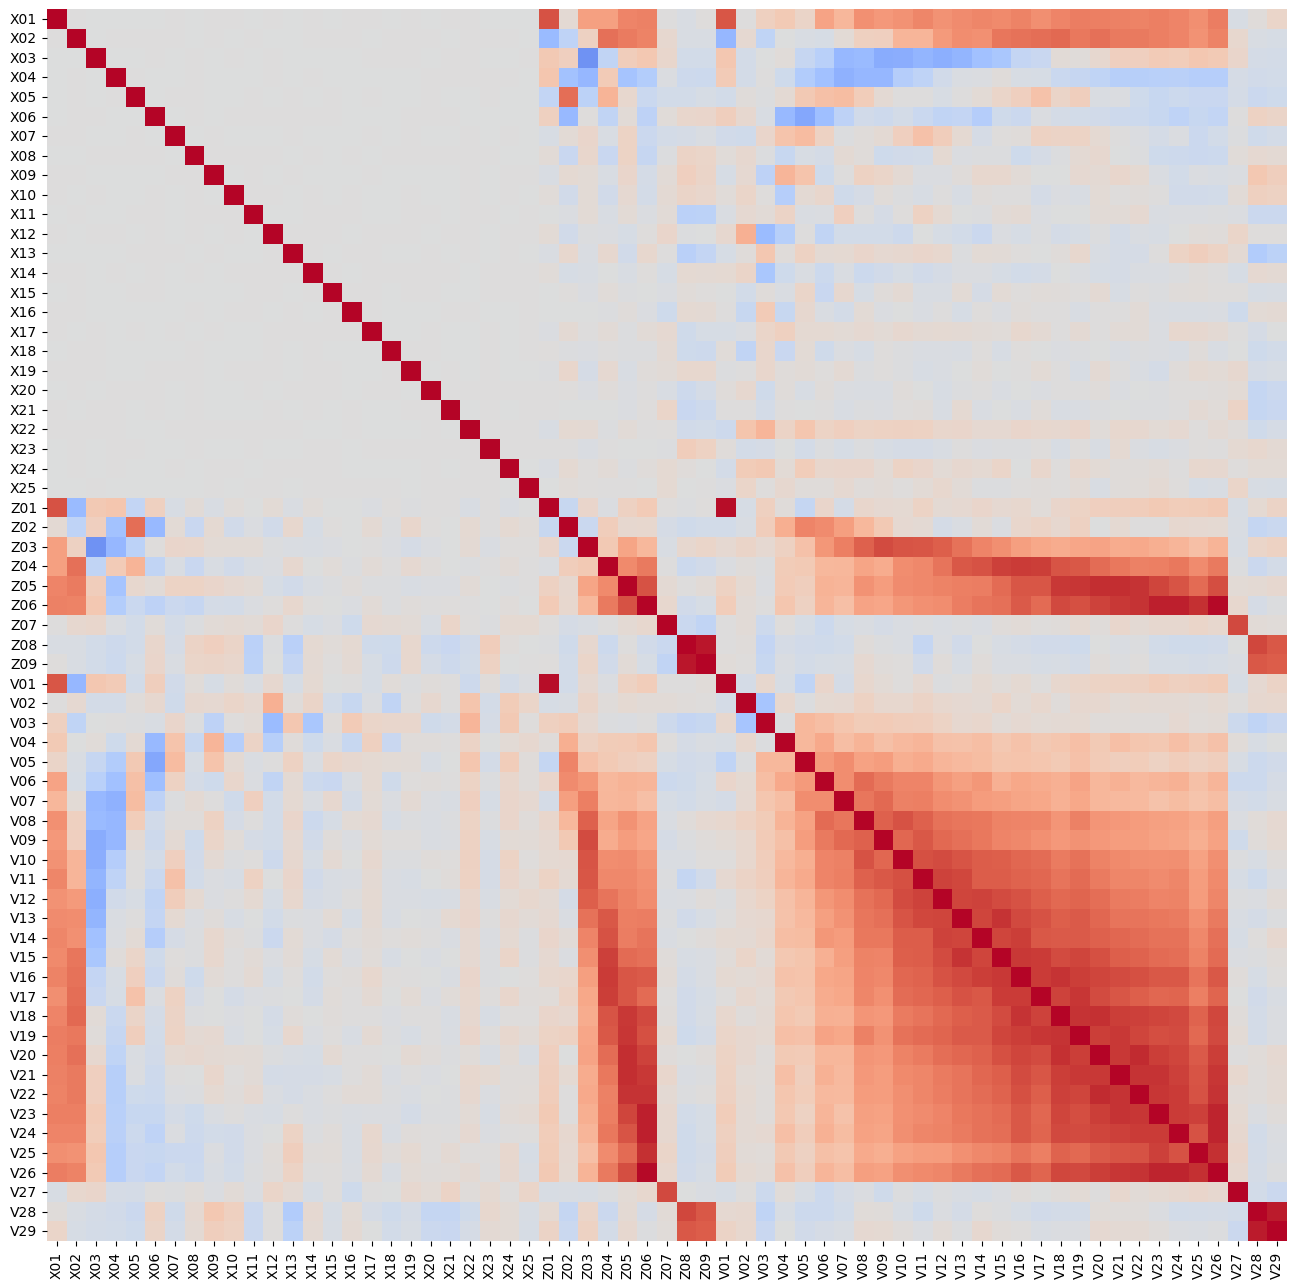

In [42]:
fig, ax = plt.subplots(figsize=(16,16))

sns.heatmap(data = df_clean.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm', cbar=False,
            ax=ax)

plt.show()

Here we can see that the features are correlated.

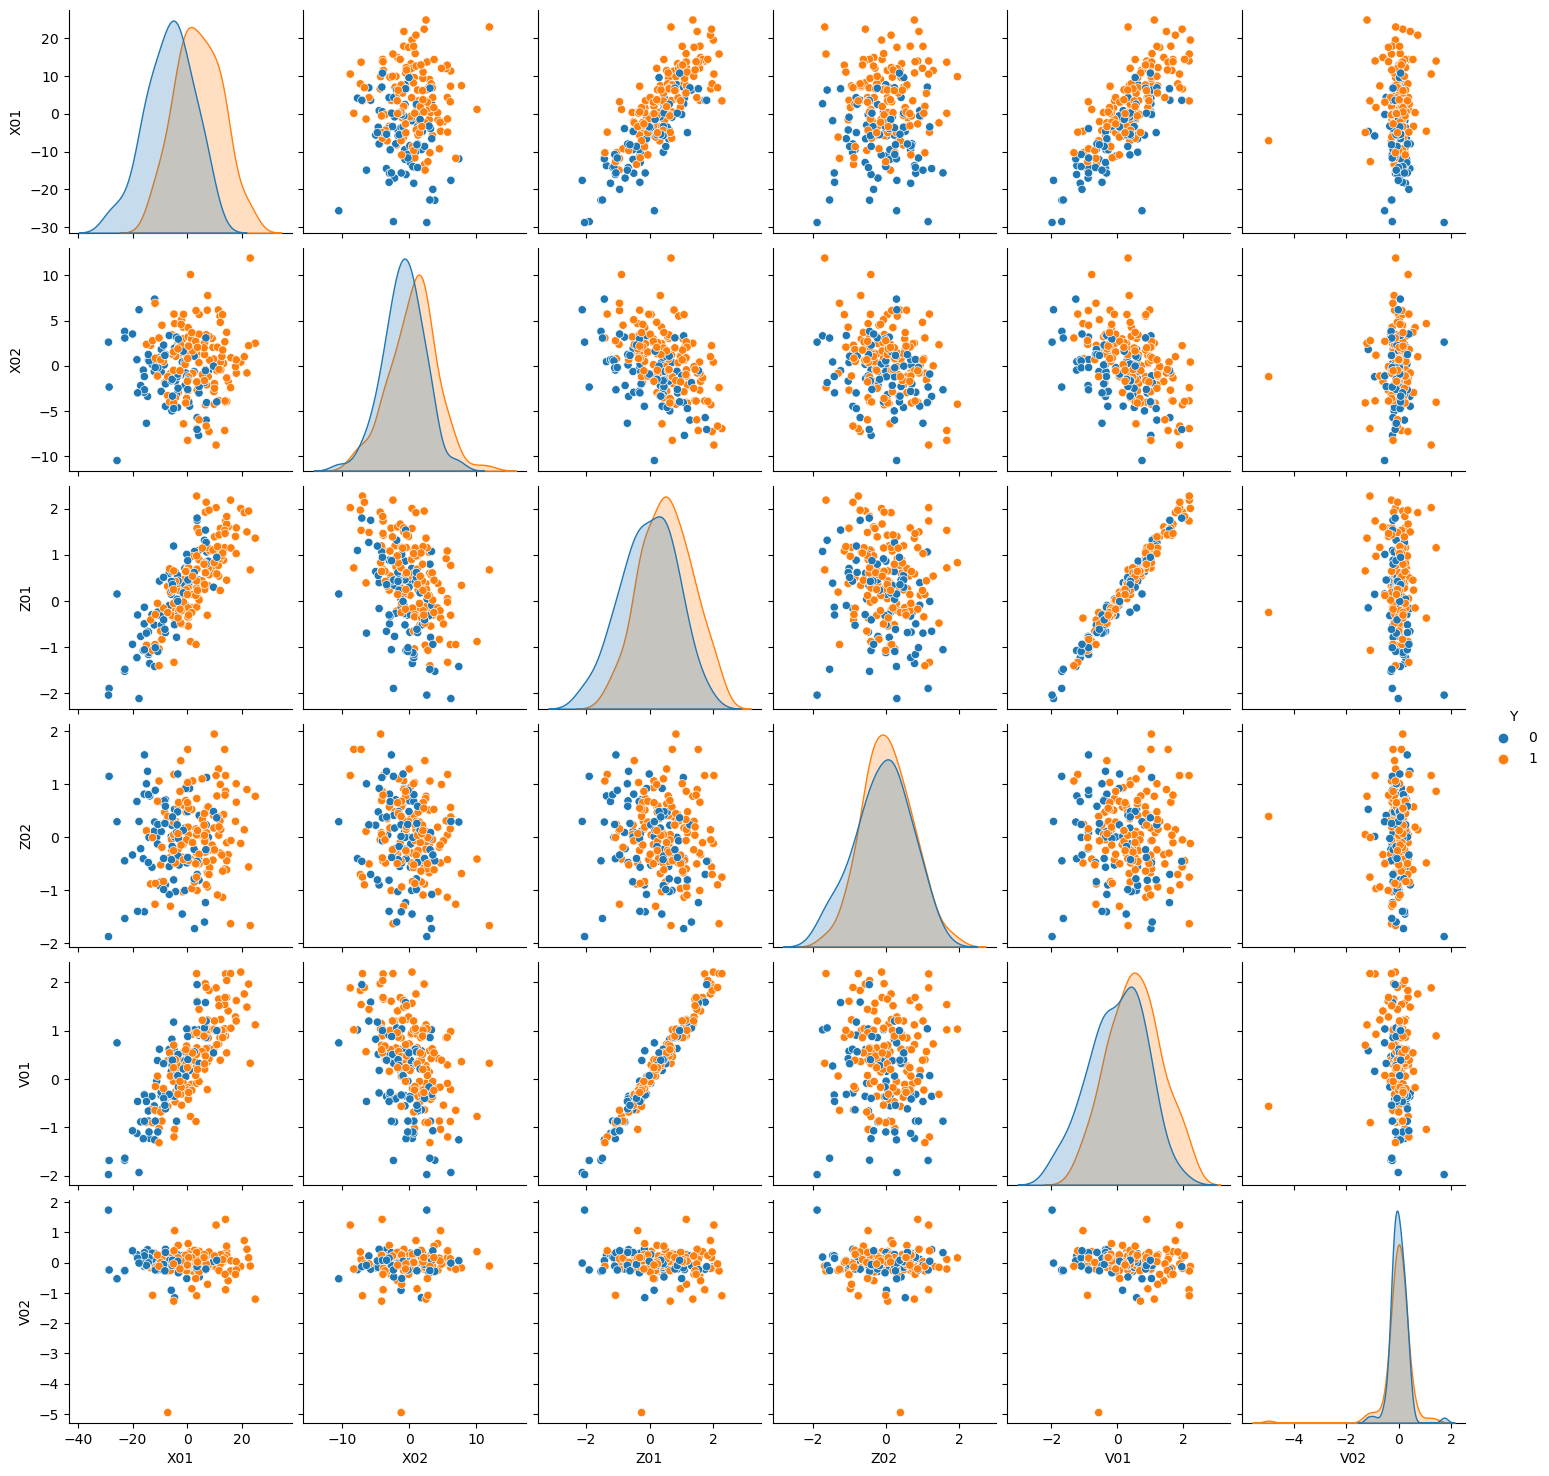

In [47]:
sns.pairplot(data=df_part_features, hue='Y', diag_kws={'common_norm': False})

plt.show()

Later on we will see that in cluster with PCA we will see better separation.

#### Cluster Analysis

In [54]:
from sklearn.preprocessing import StandardScaler

Xpoli= StandardScaler().fit_transform(df_clean_copy_features)

We will removed the scale effect then apply KMeans.

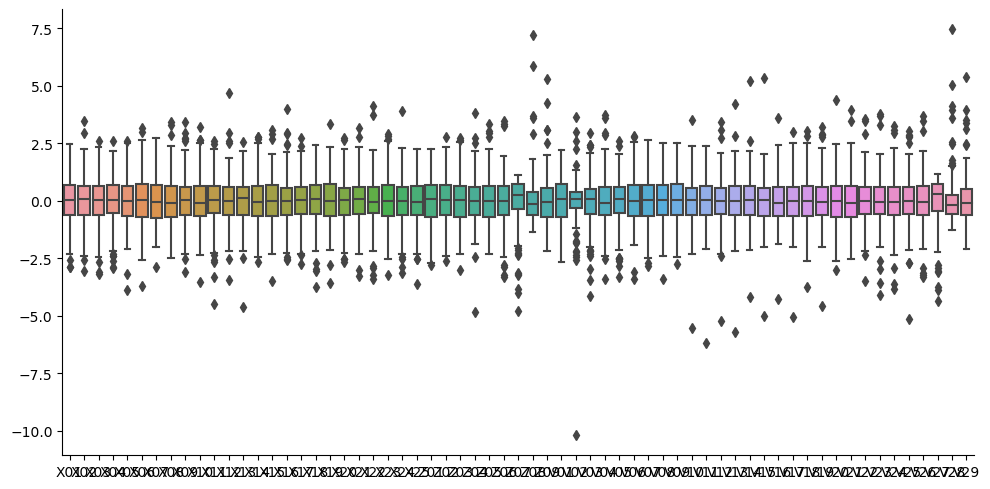

In [56]:
sns.catplot(data = pd.DataFrame(Xpoli, columns=df_clean_copy_features.columns),
            kind='box', aspect=2)

plt.show()

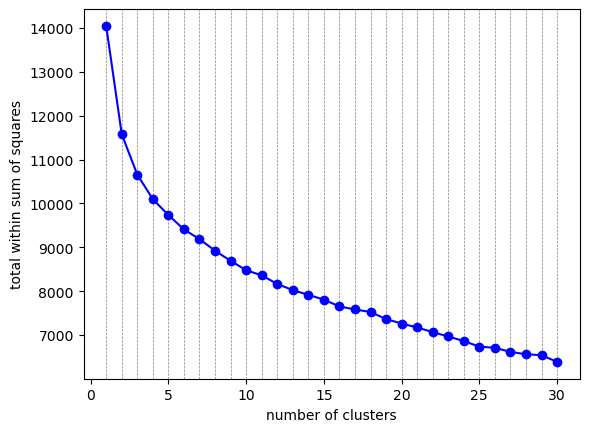

In [ ]:
opt_clus=[]

K = range(1, 31)

for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    km = km.fit(Xpoli)
    
    opt_clus.append(km.inertia_)
    
fig, ax =plt.subplots()

for x_value in range(1, max(K) + 1):
    ax.axvline(x=x_value, color='gray', linewidth=0.5, linestyle='--')
    
ax.plot(K, opt_clus, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

#ax.set_ylim(0, max(opt_clus) + 10000)  # Adjust the upper limit as needed

plt.show()

We can see from the knee bend plot that choosing 2 clusters is a good choice.

In [64]:
clusters_2 = KMeans(n_clusters=2, random_state=121, n_init=25, max_iter=500).\
    fit_predict( Xpoli )

In [65]:
df_clean_copy['k2']=pd.Series(clusters_2, index=df_clean_copy.index).astype('category')

In [66]:
df_clean_copy.k2.value_counts()

1    119
0    104
Name: k2, dtype: int64

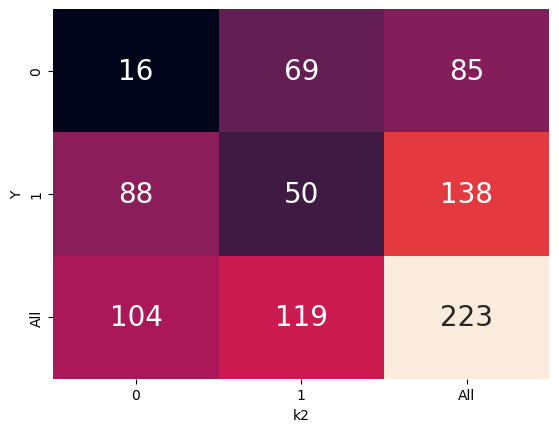

In [67]:
fig, ax = plt.subplots()

sns.heatmap(data = pd.crosstab( df_clean_copy.Y, df_clean_copy.k2, margins=True),
            annot=True, annot_kws={'fontsize': 20}, fmt='g',
            cbar=False,
            ax=ax )

plt.show()

Out of 104 rows corresponding to `k2=0`, 88 of them falls into `Y=1` with Prob(Y=1|k2=0)=88/104 and Hence we can say if a machine falls under the category `k2=0` there is a high probability that it is going to fail soon.

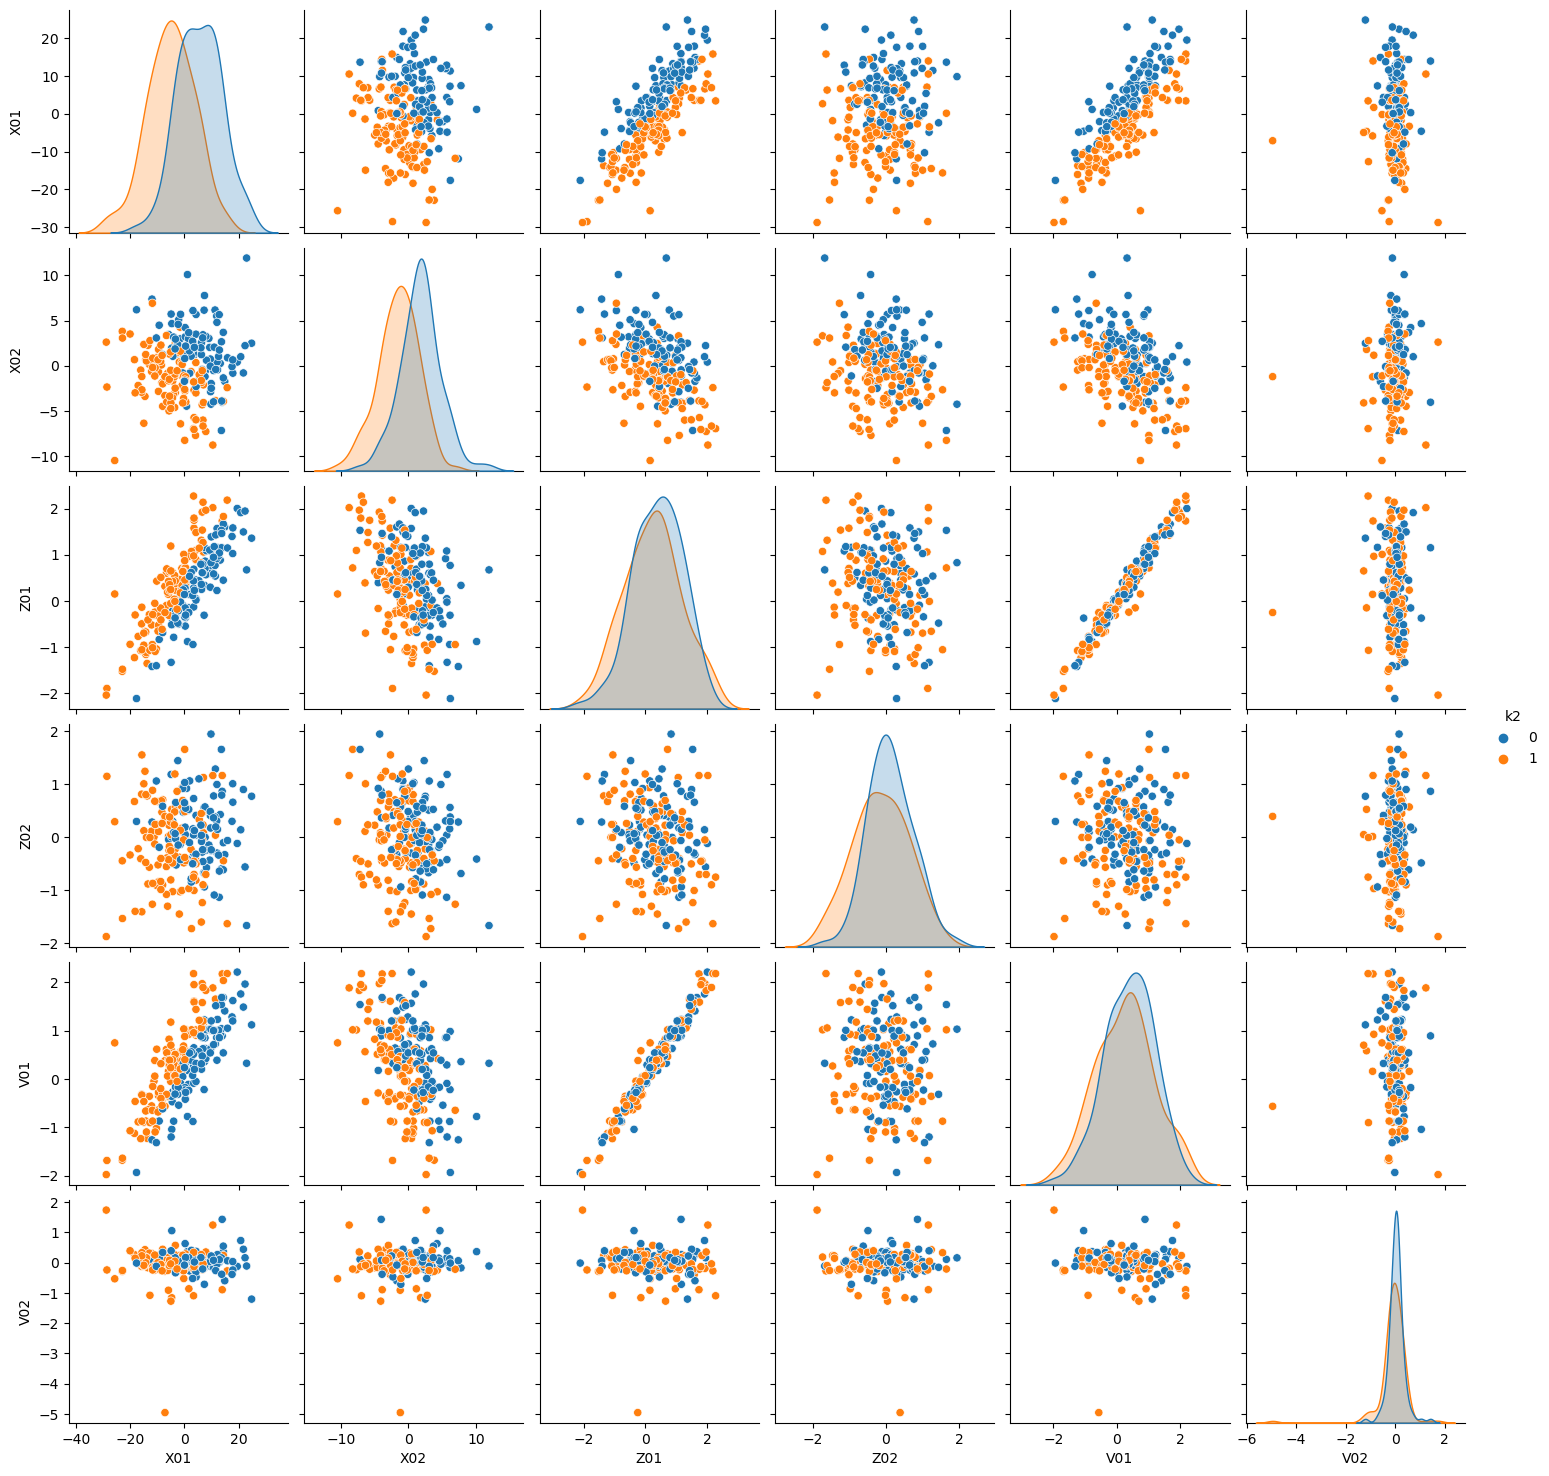

In [68]:
df_clean_copy_part_features = df_clean_copy[['X01','X02','Z01','Z02', 'V01', 'V02','k2' ]].copy()
sns.pairplot(data=df_clean_copy_part_features, hue='k2', diag_kws={'common_norm': False})

The separation is not very good as of now. There are several reasons to find out. One reason we ill see in later sections that the features are uncorrelated. So we expect to see a better separation with PCA.

In [69]:
from sklearn.decomposition import PCA

pca_poli = PCA(n_components=2).fit_transform( Xpoli )

In [70]:
pca_poli_df = pd.DataFrame( pca_poli, columns=['pc01', 'pc02'] )


In [71]:
pca_poli_df['Y']=df_clean_copy.Y

In [72]:
pca_poli_df['k2']=df_clean_copy.k2

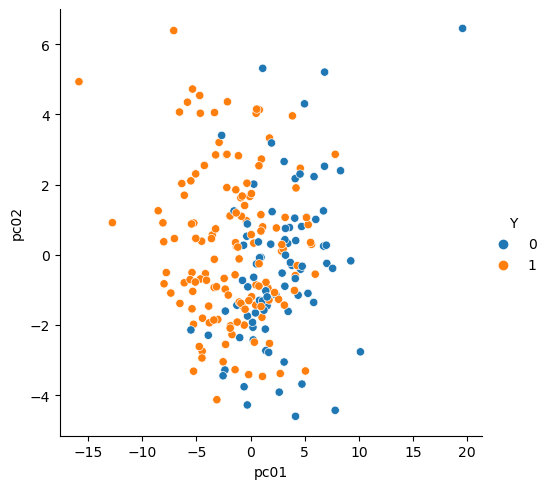

In [73]:
sns.relplot(data = pca_poli_df, x='pc01', y='pc02', hue='Y')

plt.show()

A better separation with hue in k2 as they are programme compatible.

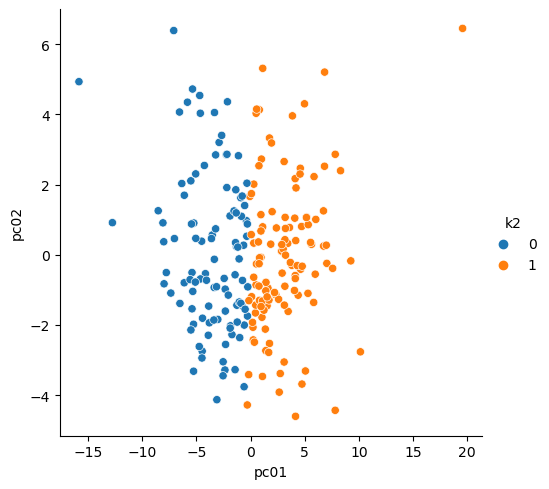

In [74]:
sns.relplot(data = pca_poli_df, x='pc01', y='pc02', hue='k2')

plt.show()

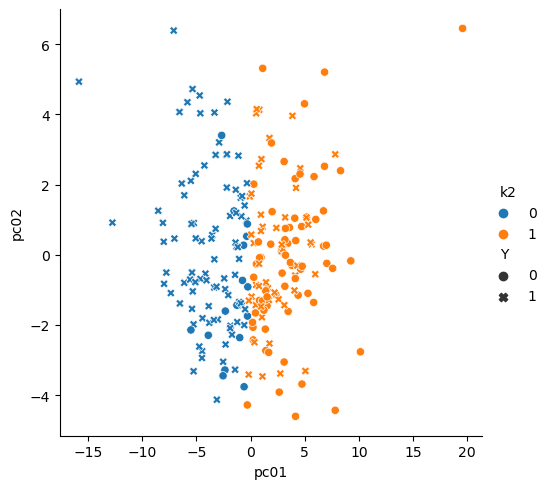

In [75]:
sns.relplot(data = pca_poli_df, x='pc01', y='pc02', hue='k2', style='Y')

plt.show()

With Hierarchical clustering also, we can see that 2 clusters is a good separation.

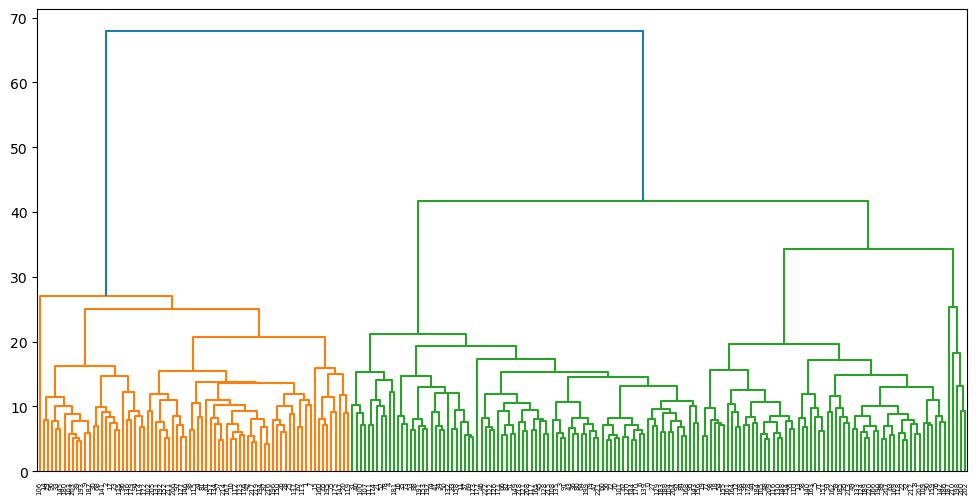

In [76]:
from scipy.cluster import hierarchy

hclust_ward = hierarchy.ward( Xpoli )

fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram( hclust_ward )

plt.show()

Later on in models I also see that V07, V15 are statistically significant. Hence, I have separated the data with k2 using V07 and V15.

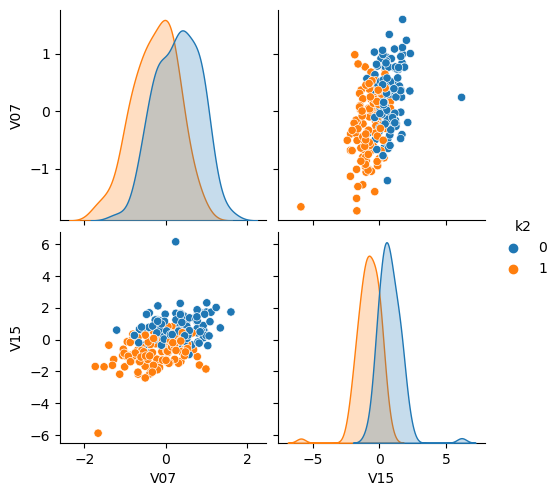

In [77]:
df_clean_copy_part_features = df_clean_copy[['V07', 'V15', 'k2' ]].copy()
sns.pairplot(data=df_clean_copy_part_features, hue='k2',diag_kws={'common_norm': False})

plt.show()

#### Models

We have studied several models but I will focus on two of them.

**Model 3**

In [93]:
formula_linear = 'Y ~ ' + ' + '.join(df_standardized_transformed.drop(columns= 'Y').columns)
mod_03 = smf.ols(formula=formula_linear, data=df_standardized_transformed).fit() 

In [94]:
mod_03.params

Intercept    0.618834
X01         -0.593080
X02          0.123625
X03         -0.000392
X04          0.124743
               ...   
V29          0.039919
Z07          0.353333
Z08         -0.007782
V27         -0.356414
V28         -0.287535
Length: 64, dtype: float64

**Model 7**

In [102]:
# Apply PCA to the transformed inputs and create all pairwise interactions between the PCs.
df_pca_transformed_int = df_pca_transformed.iloc[:, :11].copy()
df_pca_transformed_int['Y'] = df_transformed.Y
formula_int = 'Y ~ ' + ' ( '  + ' + '.join(df_pca_transformed_int.drop(columns= 'Y').columns) + ' ) ** 2'
mod_07 = smf.ols(formula=formula_int, data=df_pca_transformed_int).fit() 
mod_07.params

Intercept    0.618834
pc01        -0.085394
pc02         0.042771
pc03        -0.053285
pc04        -0.072074
               ...   
pc08:pc10    0.018514
pc08:pc11    0.032776
pc09:pc10   -0.109349
pc09:pc11   -0.057338
pc10:pc11   -0.017328
Length: 67, dtype: float64

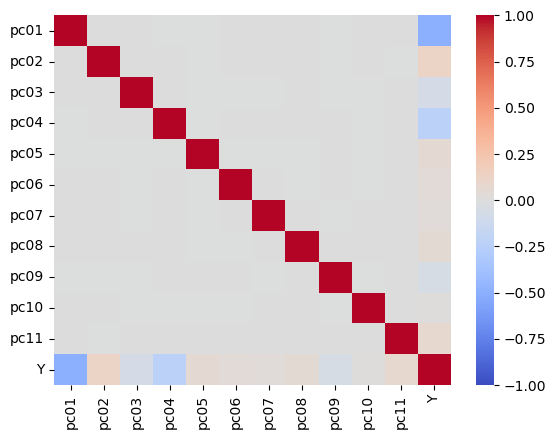

In [103]:
fig, ax = plt.subplots()

sns.heatmap(data = df_pca_transformed_int.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm',
            ax=ax)

plt.show()

Hence, all the feature components are uncorrelated.

#### Accuracy on training set

In [104]:
def fit_and_assess_logistic(a_mod, train_data, threshold, mod_name):
    
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )
    
    TN, FP, FN, TP = confusion_matrix( train_copy.Y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()
    
    Accuracy = (TN + TP) / (TN + FP + FN + TP)
    
    Sensitivity = (TP) / (TP + FN)
    
    Specificity = (TN) / (TN + FP)
    
    FPR = 1 - Specificity
    
    ROC_AUC = roc_auc_score( train_copy.Y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_dict = {'model_name': mod_name,
                'num_coefs': len( a_mod.params ),
                'threshold': threshold,
                'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}
    return pd.DataFrame( res_dict, index=[0] )
    

In [107]:
result=[]

result.append(fit_and_assess_logistic(mod_03, df_standardized_transformed, 0.5,'mod_03'))

In [108]:
result.append(fit_and_assess_logistic(mod_07, df_pca_transformed_int, 0.5,'mod_07'))

In [109]:
results_df = pd.concat( result, ignore_index=True)

In [110]:
results_df

,model_name,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,mod_03,64,0.5,0.869955,0.913043,0.800000,0.200000,0.928815
1,mod_07,67,0.5,0.896861,0.898551,0.894118,0.105882,0.954390


#### Predictions on unseen data

In [111]:
mod_03_pvalues = mod_03.pvalues[mod_03.pvalues<0.05].sort_values()
mod_03_pvalues

Intercept    6.959566e-52
V07          2.983129e-02
V15          3.528132e-02
dtype: float64

In [121]:
np.abs(mod_03.params).sort_values()

V12          0.000306
X03          0.000392
X21          0.000834
X12          0.001298
V09          0.002728
               ...   
V27          0.356414
Z01          0.527619
Z04          0.532705
X01          0.593080
Intercept    0.618834
Length: 64, dtype: float64

Hence, 'X01', 'Z04', 'Z01' are three chosen significant inputs.

In [122]:
input_grid_03 = pd.DataFrame([ (X01, Z04, Z01)   
for X01 in np.linspace(df_standardized.X01.min(), df_standardized.X01.max(), num=101)
for Z04 in np.linspace(df_standardized.Z04.min(), df_standardized.Z04.max(), num=5)
for Z01 in np.linspace(df_standardized.Z01.min(), df_standardized.Z01.max(), num=5)],
                          columns=['X01', 'Z04', 'Z01'])

In [123]:
# Assign constant values for all other inputs
df_new = df_standardized.drop(columns=['Y'])
for column in df_new.columns:
    if column not in ['X01', 'Z04', 'Z01']:
        input_grid_03[column] = df_standardized[column].mean()

In [124]:
input_grid_03.shape

(2525, 63)

In [125]:
input_grid_03.nunique()

X01    101
Z04      5
Z01      5
X02      1
X03      1
      ... 
V25      1
V26      1
V27      1
V28      1
V29      1
Length: 63, dtype: int64

In [126]:
dfviz_03 = input_grid_03.copy()

In [127]:
dfviz_03['pred_probability_03'] = mod_03.predict( input_grid_03 )

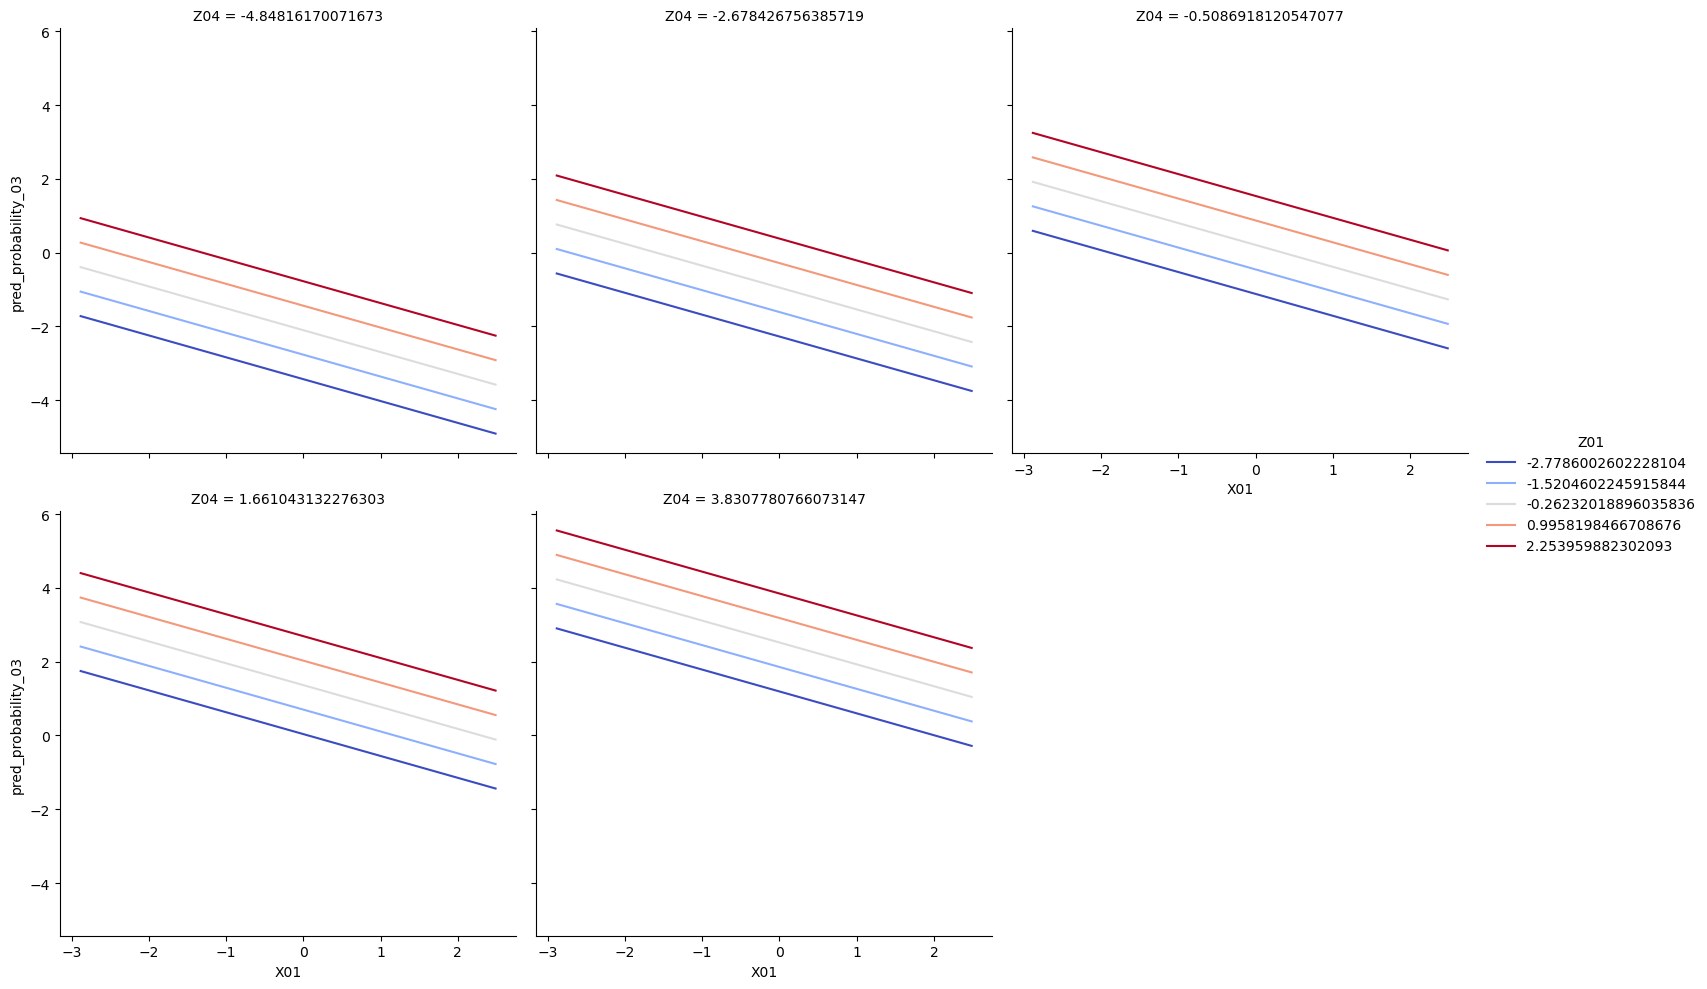

In [128]:
# hue = X17
sns.relplot(
    data=dfviz_03,
    x='X01',
    y='pred_probability_03',
    hue='Z01',
    col='Z04',
    kind='line',
    estimator=None,
    units='Z01',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

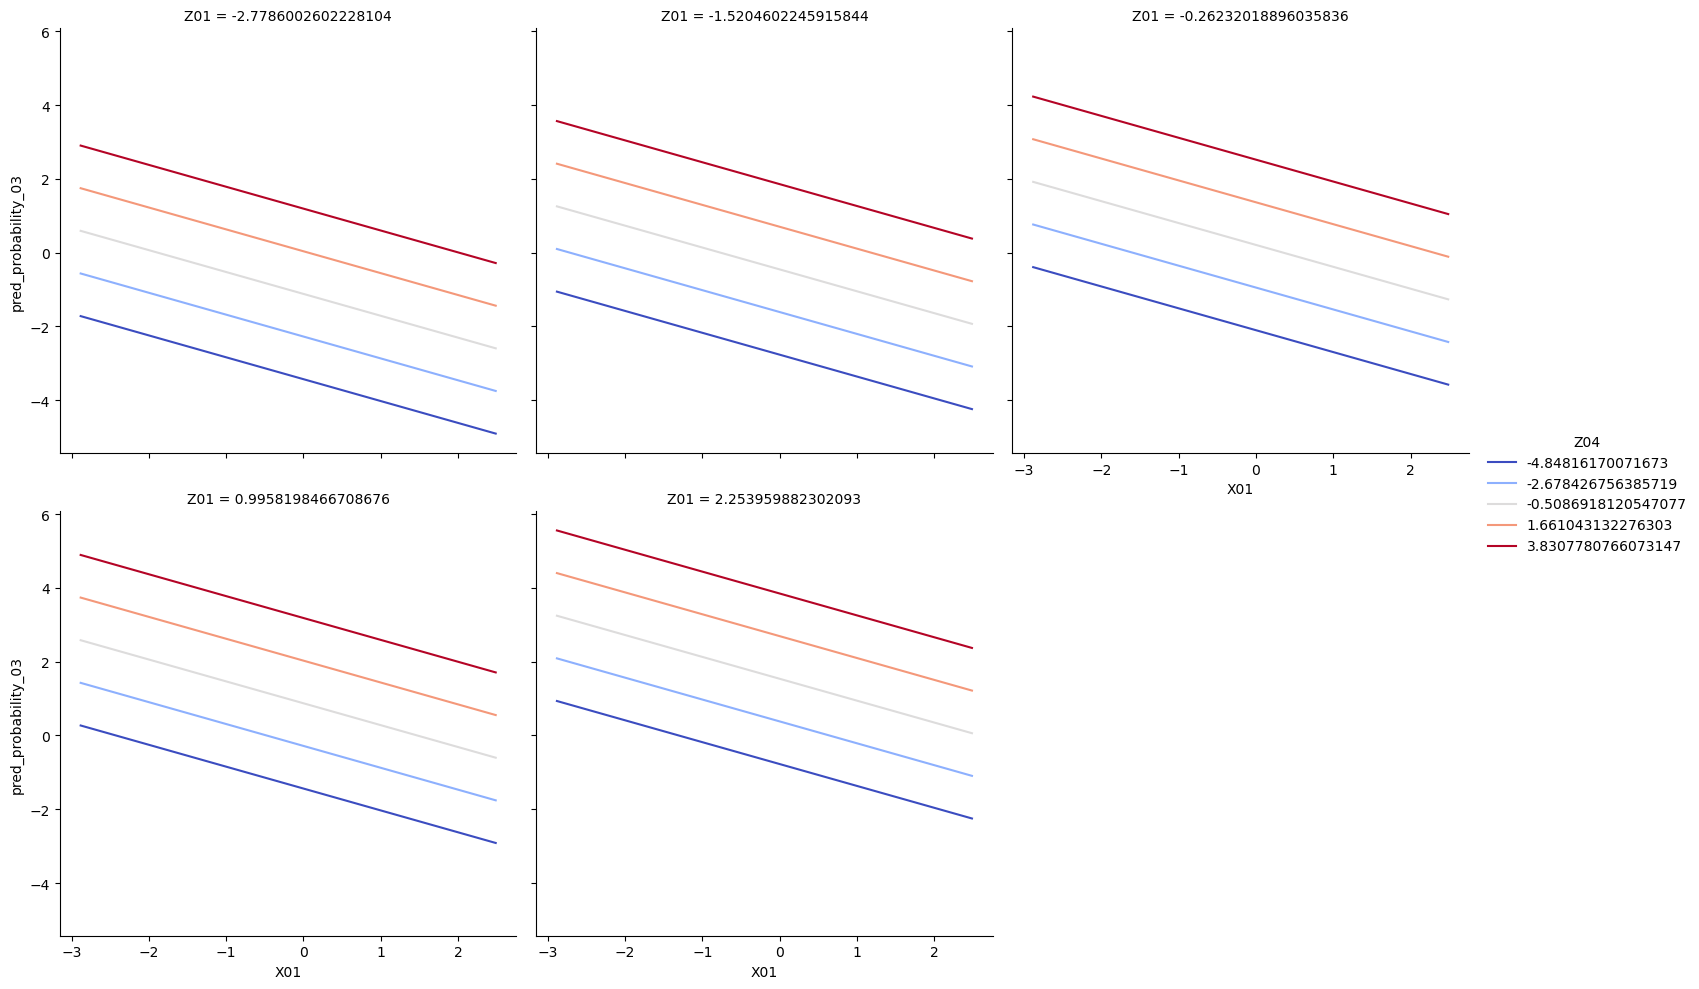

In [129]:
# hue = X02
sns.relplot(
    data=dfviz_03,
    x='X01',
    y='pred_probability_03',
    hue='Z04',
    col='Z01',
    kind='line',
    estimator=None,
    units='Z04',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

We observe that model prediction plot increases(shifts upwards) as Z04 increases for various values of Z01. We also observe that model prediction plot increases (moves upwards) as Z01 increases for various values of Z04.

### Model 7

We need to identify 3 most important features for prediction.

In [130]:
# Assuming mod_07.pvalues is a NumPy array
np.abs(mod_07.params).sort_values()

pc05:pc06    0.000743
pc01:pc05    0.000845
pc01:pc02    0.001042
pc06:pc10    0.001150
pc10         0.001319
               ...   
pc04         0.072074
pc11         0.078232
pc01         0.085394
pc09:pc10    0.109349
Intercept    0.618834
Length: 67, dtype: float64

In [131]:
input_grid_07 = pd.DataFrame([ (pc01, pc11, pc04)                
for pc01 in np.linspace(df_pca_transformed_int.pc01.min(),
                        df_pca_transformed_int.pc01.max(), num=101)
for pc11 in np.linspace(df_pca_transformed_int.pc11.min(),
                        df_pca_transformed_int.pc11.max(), num=5)
for pc04 in np.linspace(df_pca_transformed_int.pc04.min(),
                        df_pca_transformed_int.pc04.max(), num=5)],
                          columns=['pc01', 'pc11', 'pc04'])

In [132]:
# Assign constant values for all other inputs
df_new = df_pca_transformed_int.drop(columns=['Y'])
for column in df_new.columns:
    if column not in ['pc01', 'pc11', 'pc04']:
        input_grid_07[column] = df_new[column].mean()

In [133]:
dfviz_07 = input_grid_07.copy()

In [137]:
dfviz_07['pred_probability_07'] = mod_07.predict( input_grid_07 )

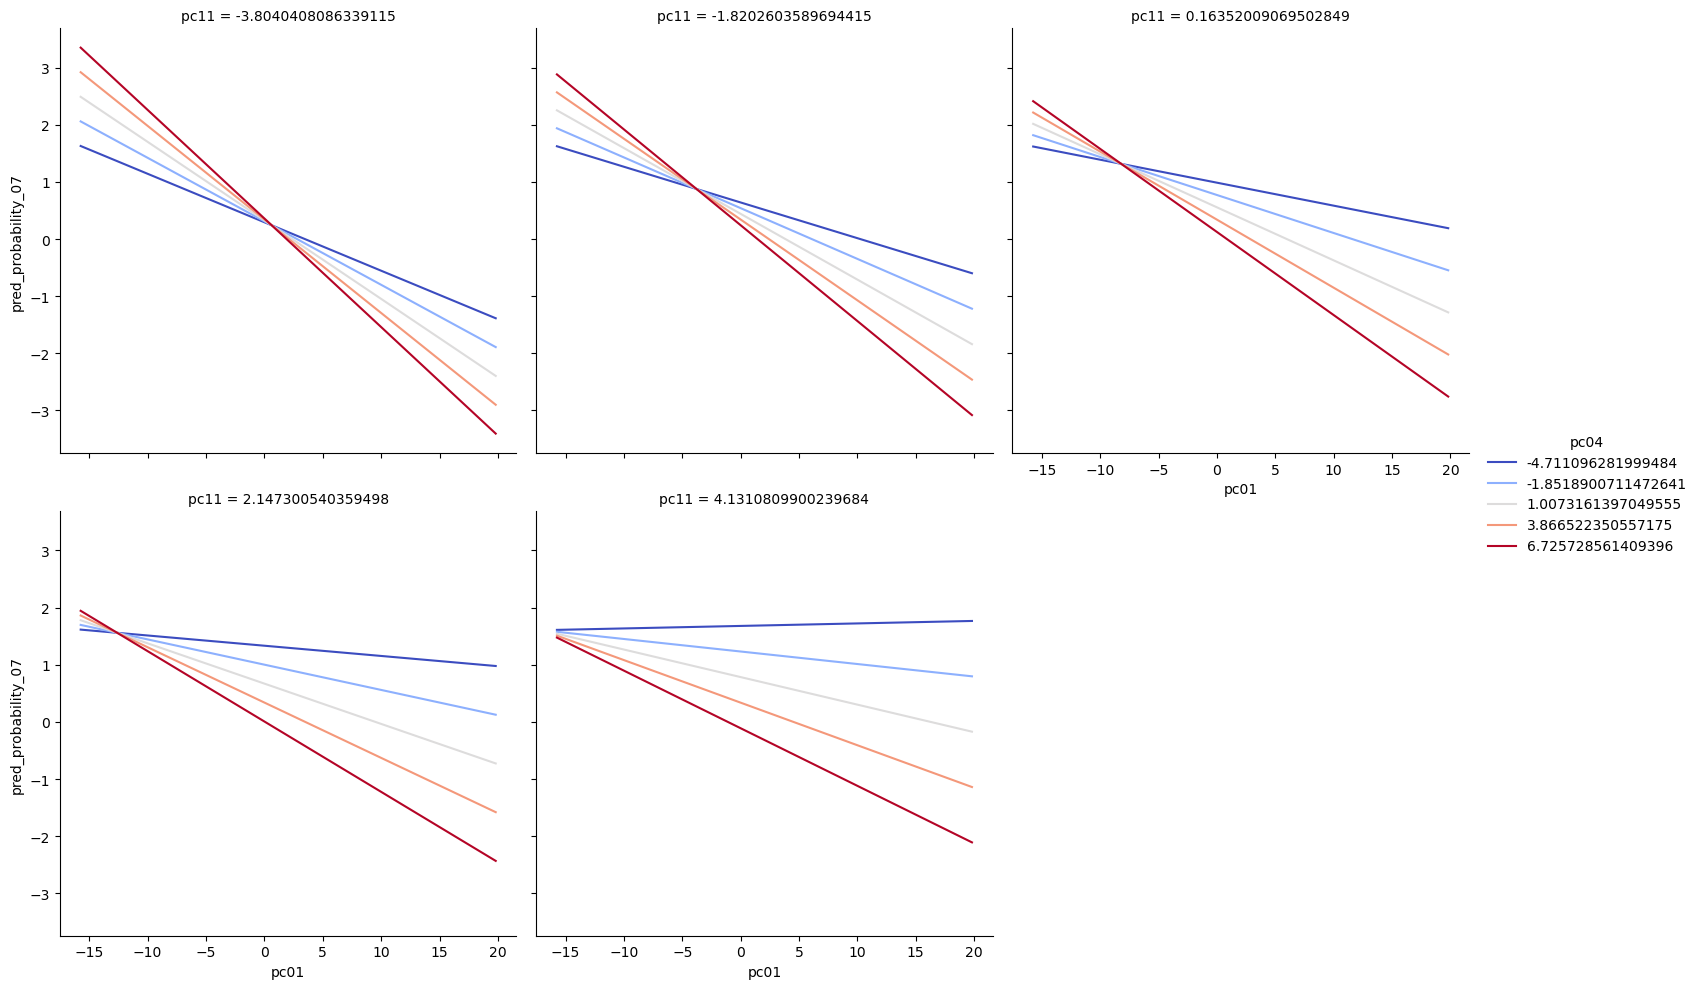

In [138]:
# hue = pc05
sns.relplot(
    data=dfviz_07,
    x='pc01',
    y='pred_probability_07',
    hue='pc04',
    col='pc11',
    kind='line',
    estimator=None,
    units='pc04',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

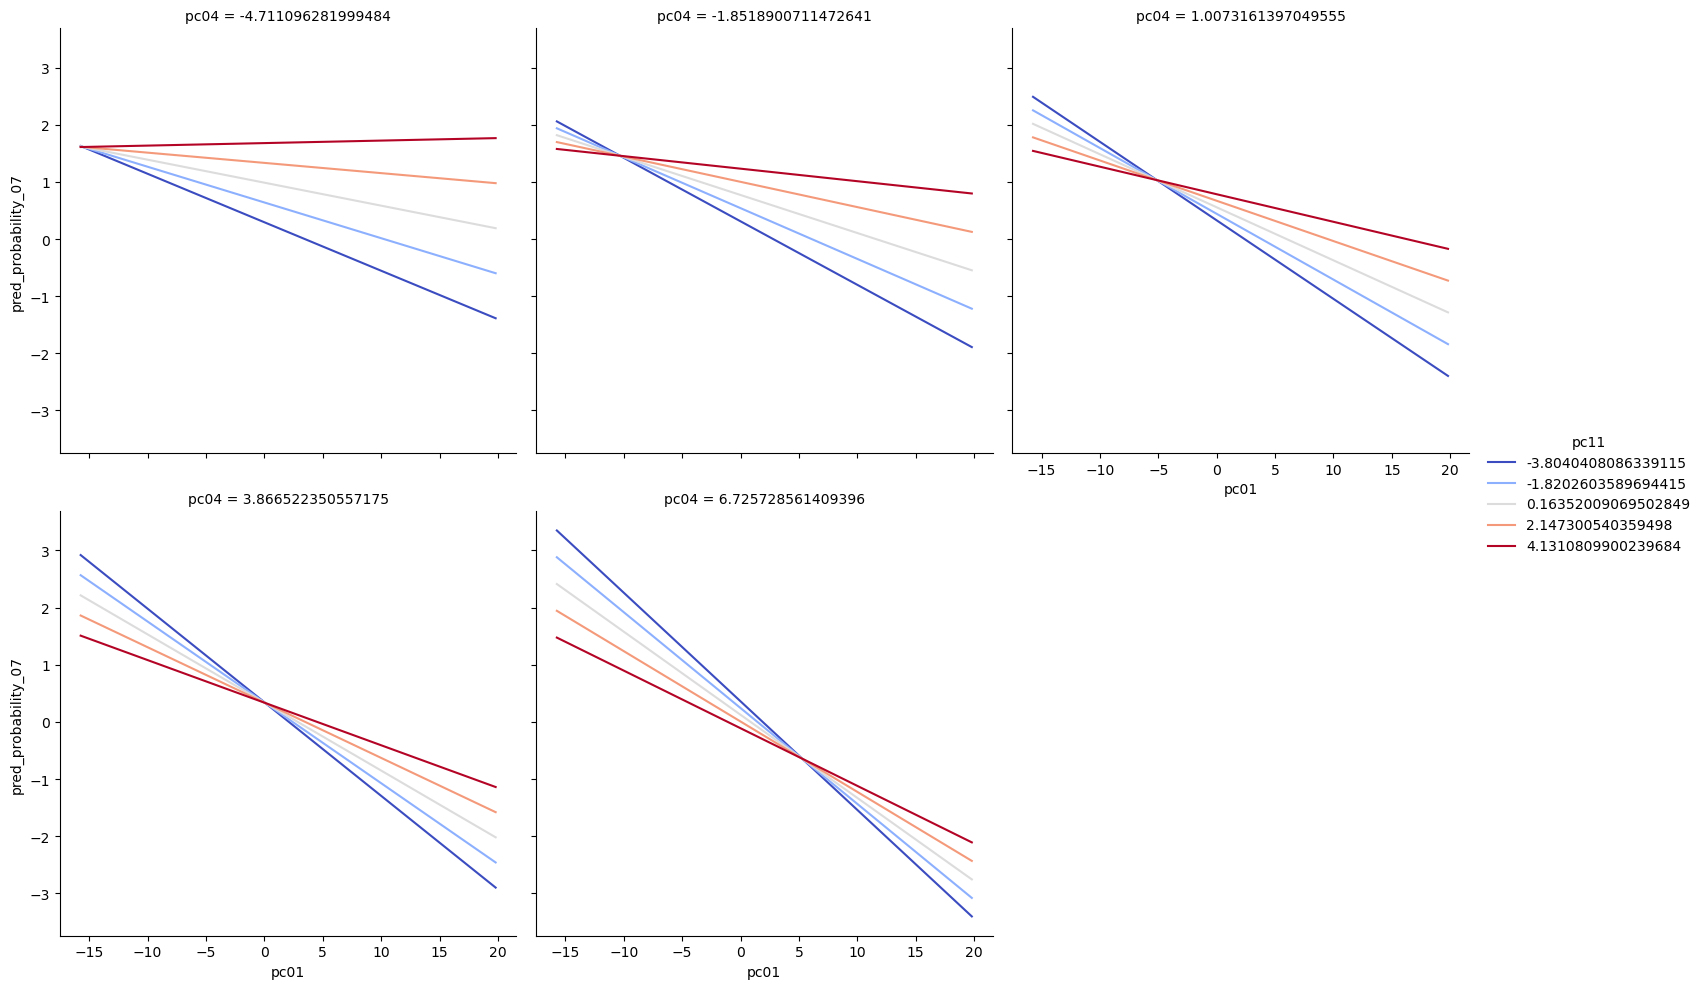

In [139]:
# hue = pc06
sns.relplot(
    data=dfviz_07,
    x='pc01',
    y='pred_probability_07',
    hue='pc11',
    col='pc04',
    kind='line',
    estimator=None,
    units='pc11',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

The model prediction plot has negative slope for pc04$>-2$ and the slopes are increasing as pc11 increases. positive slope for pc $04=-4.7$ and pc $11=4.13$. 

We also observe that the plot decreases(shifts downwards) as pc04 values increases( for all values of pc11).



#### Performance

**First Model**

Let us first start with Elastic net on the entire feature variables. We will apply the elastic net regularization.

In [140]:
xinputs = df.drop(columns=['Y'].copy())
youtput = df.loc[:, ['Y']].copy()

In [141]:
#Convert the DataFrames to NumPy arrays.
x_train = xinputs.to_numpy()
y_train = youtput.Y.to_numpy().ravel()

In [142]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga', random_state=202, max_iter=25001, fit_intercept=True)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [143]:
enet_wflow_df = Pipeline(steps=[('std_inputs', StandardScaler()), 
                             ('enet', enet_to_fit)] )

In [144]:
enet_grid = {'enet__C': np.exp( np.linspace(-10, 10, num=17) ),
             'enet__l1_ratio': np.linspace(0, 1, num=3)}

In [145]:
enet_search = GridSearchCV(enet_wflow_df, param_grid=enet_grid, cv=kf)

In [146]:
enet_search_results = enet_search.fit( x_train, y_train )

In [147]:
enet_search_results.best_params_

{'enet__C': 0.0820849986238988, 'enet__l1_ratio': 0.0}

Basically Ridge because of the correlation factor. This indicates that we should try PCA as well.

In [148]:
enet_search_results.best_score_

0.7533333333333333

**Second Model(Improved version)**

We will apply PCA to the original inputs and cosider additive version. We will use lasso because we are anyway going to apply PCA which will make the features uncorrelated and lasso will help reducing the number of effective features. We can start with elastic net as well but we are trying to reduce the complexity.

In [149]:
enet_search_results.best_score_

0.7533333333333333

In [157]:
lasso_to_fit = LogisticRegression(penalty='l1', solver='saga', random_state=202, max_iter=25001, fit_intercept=True)

In [158]:
pc_wflow_df = Pipeline( steps=[('std_inputs', StandardScaler()), 
                                  ('pca', PCA()),
                              ('lasso', lasso_to_fit)] )

In [159]:
pc_grid = {'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 17],
                 'lasso__C': np.exp( np.linspace(-10, 10, num=17) ) }

In [160]:
pc_df_search = GridSearchCV(pc_wflow_df, param_grid=pc_grid, cv=kf)

In [161]:
pc_df_search_results = pc_df_search.fit( x_train, y_train )

In [162]:
pc_df_search_results.best_params_

{'lasso__C': 42.52108200006278, 'pca__n_components': 13}

In [163]:
pc_df_search_results.best_score_

0.775959595959596

The accuracy increased a bit. Now further modification.

**Third Model** 
Apply not only PCA but also interaction.

In [164]:
xinputs_transformed = df_transformed.select_dtypes('number').copy()
youtput_transformed = df_transformed.loc[:, ['Y']].copy()

In [176]:
#Convert the DataFrames to NumPy arrays.
x_train_transformed = xinputs_transformed.to_numpy()
y_train_transformed = youtput_transformed.Y.to_numpy().ravel()

In [177]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform( x_train_transformed ).shape

(223, 2080)

In [167]:
make_pairs = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [168]:
pc_interact_lasso_wflow = Pipeline( steps=[('std_inputs', StandardScaler() ), 
                                           ('pca', PCA() ), 
                                           ('make_pairs', make_pairs), 
                                           ('lasso', lasso_to_fit )] )

In [169]:
pc_interact_lasso_search = GridSearchCV( pc_interact_lasso_wflow, param_grid=pc_grid, cv=kf )

In [170]:
pc_interact_lasso_search_grid = pc_interact_lasso_search.fit( x_train_transformed, y_train_transformed )

In [171]:
pc_interact_lasso_search_grid.best_params_

{'lasso__C': 0.2865047968601901, 'pca__n_components': 11}

In [172]:
coef = pc_interact_lasso_search_grid.best_estimator_.named_steps['lasso'].coef_

In [173]:
# model 3-Apply PCA to the transformed inputs and create all pairwise interactions between the PCs
pc_interact_lasso_search_grid.best_score_

0.8387878787878786

In [174]:
# Model 2 - Apply PCA to the original inputs and create linear additive features 
pc_df_search_results.best_score_

0.775959595959596

In [175]:
# Model 1 - Linear additive features using the original inputs
enet_search_results.best_score_

0.7533333333333333

Which model is the BEST according to CROSS-VALIDATION?

Ans: The third model or mod_07 where we applied PCA to the transformed inputs and create all pairwise interactions between the PCs is the best model

• Is this model DIFFERENT from the model identified as the BEST according
to the training set?

Ans: No

• How many regression coefficients are associated with the best model?

Ans: 41

#### Performance

#### Elastic net
* Apply the ELASTIC NET penalty to the MOST complex model you fit even if CROSS-VALIDATION says it is NOT the best model.
* Train and tune an ELASTIC NET penalized model by optimizing BOTH tuning parameters via CROSS-VALIDATION.
* Examine the final tuned coefficients estimates. Is the tuned model closer to RIDGE or LASSO? Are the final tuned coefficients zero?

In [178]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga',
                            random_state=202, max_iter=25001, fit_intercept=True)

In [179]:
pc_interact_enet_wflow = Pipeline( steps=[('std_inputs', StandardScaler() ), 
                                           ('pca', PCA() ), 
                                           ('make_pairs', make_pairs), 
                                           ('enet', enet_to_fit )] )

In [180]:
enet_grid = {'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 17],
             'enet__C': np.exp( np.linspace(-10, 10, num=17)),
             'enet__l1_ratio': np.linspace(0, 1, num=3)}

In [181]:
pc_df_enet_search = GridSearchCV(pc_interact_enet_wflow, param_grid=enet_grid, cv=kf)

In [182]:
pc_df__enet_search_results = pc_df_enet_search.fit( x_train_transformed, y_train_transformed )

In [187]:
#The optimal value for C and no. of pca components is 
pc_df__enet_search_results.best_params_

{'enet__C': 0.0820849986238988, 'enet__l1_ratio': 0.5, 'pca__n_components': 11}

In [188]:
pc_df__enet_search_results.best_score_

0.8387878787878786

In [189]:
coef = pc_df__enet_search_results.best_estimator_.named_steps['enet'].coef_
print(coef)

[[-4.61643371e-01  1.51956076e-01 -2.27193049e-01 -3.30726075e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.64209540e-01  0.00000000e+00
  -1.76632324e-02 -9.33136155e-02 -2.85416074e-04  6.73908386e-03
  -3.97768323e-02  0.00000000e+00  0.00000000e+00 -6.50276343e-02
   7.16484640e-02  1.41656897e-02  0.00000000e+00  6.79600580e-03
  -9.57486696e-03 -3.57824024e-02 -6.65629264e-02  1.11382553e-01
  -8.82917508e-03 -1.94534769e-02 -3.93631624e-02 -1.20096487e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.28482648e-02  0.00000000e+00 -6.17084977e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.31720562e-01 -1.31093477e-02
  -1.31297775e-01 -1.98992938e-02  4.22646920e-03  0.00000000e+00
   0.00000000e+00  9.62881470e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.76132187e-03  0.00000000e+00 -5.76938051e-02
  -1.05883066e-01  0.00000000e+00 -3.09174704e-02  0.00000000e+00
   0.00000

In [190]:
empty_elements = coef[coef == 0]
empty_elements.size

31

There are 31 zero final tuned coefficients 

# Model of your choice
* We have focused on (generalized) linear models (linear regression and logistic regression).
* You may select a non-linear model of your choice, such as Support Vector Machines, Random forests, or neural networks.
* The syntax for fitting them is VERY similar to the scikit-learn linear model and logistic regression syntax (Module 13 and Module 14).
* Use cross-validation to tune and assess performance of that model.

In [191]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [192]:
svm_model = SVC()

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')


In [193]:
svm_result=svm_grid_search.fit(x_train_transformed, y_train_transformed)

In [ ]:
svm_result.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
svm_result.best_score_

1.0

In [ ]:
svm_cross_val_scores = cross_val_score(svm_grid_search.best_estimator_, x_train_transformed, y_train_transformed, cv=5, scoring='accuracy')
print("SVM Cross-Validation Scores:", svm_cross_val_scores)
print("SVM Mean Cross-Validation Score:", svm_cross_val_scores.mean())

SVM Cross-Validation Scores: [1. 1. 1. 1. 1.]
SVM Mean Cross-Validation Score: 1.0


## Summary

In EDA we saw the inputs are highly correlated and thats why they are not very good at separating Y=0,1. The KMeans k2=0,1 worked well and it was not only giving us a better hue in scatter plot but also matched goof with Y=0,1. 

We can see that V07, V15, X10 are statistically significant features. It seems the 3rd approach at extracting patterns from the signals is more useful. 

Because they are correlated to each other we need the help of PCA to evaluate effective feature variables and at the end we saw that there are 11 to 13 such PCA features which separate the data well, hence, effective. 

The best logistic regression model turns out to be the elastic net with even mixed with ridge and lasso with 31 zero coefficients. We are getting 83-84% accuracy here. The best model in training turns out to be the best in prediction as well. At the end we saw if we use SVC then we are infact getting 100% accuracy. I have also included Neural net in the supporting document where we get 97% accuracy.